In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from phd.feature_search.core import IDBD

%matplotlib inline

In [5]:
def train(
    n_real_inputs,
    n_distractors, 
    noise_strength,
    init_step_size = 0.01,
    meta_step_size = 0.005,
    train_steps = 10_000,
    seed = None,
    device = 'cpu'
):
    if seed is None:
        seed = np.random.randint(0, 1000000)

    true_weights = torch.randn(1, n_real_inputs + 1, device=device)
    model = torch.nn.Linear(n_real_inputs + n_distractors + 1, 1, bias=False).to(device)
    torch.nn.init.zeros_(model.weight)

    optimizer = IDBD(model.parameters(), meta_lr=meta_step_size, init_lr=init_step_size, autostep=True)

    # Generate all inputs and targets upfront
    all_X = torch.randint(0, 2, (train_steps, n_real_inputs + n_distractors + 1), 
                         dtype=torch.float, device=device)
    all_X[:, 0] = 1

    # Generate sample data for normalization
    sample_X = torch.randint(0, 2, (10_000, n_real_inputs + 1,), 
                            dtype=torch.float, device=device)
    sample_X[:, 0] = 1

    sample_y = true_weights @ sample_X.T
    sample_y += torch.randn(10_000, device=device) * noise_strength

    y_mean = sample_y.mean()
    y_std = sample_y.std()

    # Pre-compute all targets
    with torch.no_grad():
        all_targets = true_weights @ all_X[:, :n_real_inputs + 1].T
        all_targets = all_targets.squeeze(0)
        all_targets += torch.randn(train_steps, device=device) * noise_strength
        all_targets = (all_targets - y_mean) / y_std

    losses = torch.zeros(train_steps, device=device)
    real_step_sizes = torch.zeros((train_steps, n_real_inputs + 1), device=device)
    distractor_step_sizes = torch.zeros((train_steps, n_distractors), device=device)

    for i in range(train_steps):
        true_X = all_X[i]
        y_pred = model(true_X).squeeze(0)
        target = all_targets[i]
        
        loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target)
        losses[i] = loss.detach()

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step(y_pred)

        # Store step sizes
        with torch.no_grad():
            step_sizes = torch.exp(list(optimizer.state.values())[0]['beta'])
            real_step_sizes[i] = step_sizes[0, :n_real_inputs + 1]
            distractor_step_sizes[i] = step_sizes[0, n_real_inputs + 1:]

    return {
        'losses': losses.cpu().numpy(),
        'real_step_sizes': real_step_sizes.cpu().numpy(),
        'distractor_step_sizes': distractor_step_sizes.cpu().numpy()
    }

Number of steps: 5000
Loss: 0.013974936


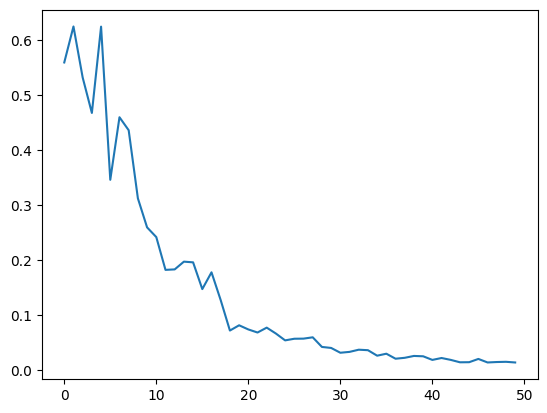

In [4]:
results = train(
    n_real_inputs = 20,
    n_distractors = 1000,
    noise_strength = 0.1,
    init_step_size = 0.01,
    meta_step_size = 0.005,
    train_steps = 5000,
    seed = 20250825,
    device = 'cuda',
)

losses = results['losses']
print('Number of steps:', len(losses))
print('Loss:', np.mean(losses[-200:]))

binned_losses = np.array(losses).reshape(-1, 100).mean(axis=1)

plt.plot(binned_losses)

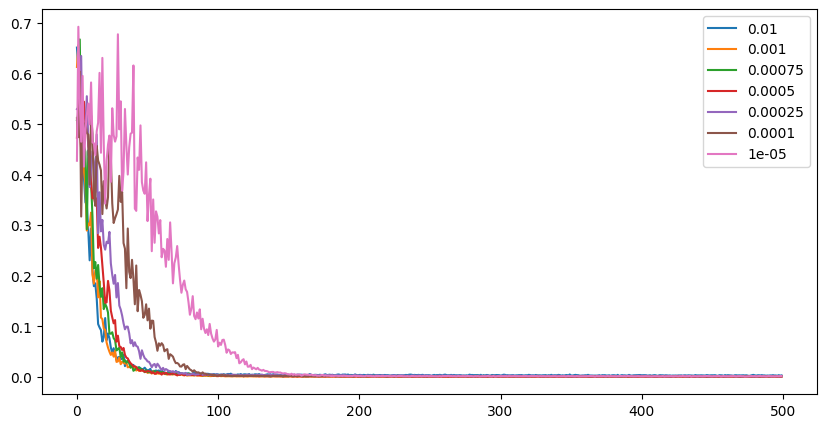

In [24]:
all_results = {}
for step_size in [0.01, 0.001, 0.00075, 0.0005, 0.00025, 0.0001, 0.00001]:
    results = train(
        n_real_inputs = 20,
        n_distractors = 1000,
        noise_strength = 0.1,
        init_step_size = step_size,
        meta_step_size = 0.005,
        train_steps = 50_000,
        seed = 20250825,
    )
    all_results[step_size] = results

plt.figure(figsize=(10, 5))

for step_size, results in all_results.items():
    losses = results['losses']
    binned_losses = np.array(losses).reshape(-1, 100).mean(axis=1)
    plt.plot(binned_losses, label=str(step_size))

plt.legend()
plt.show()

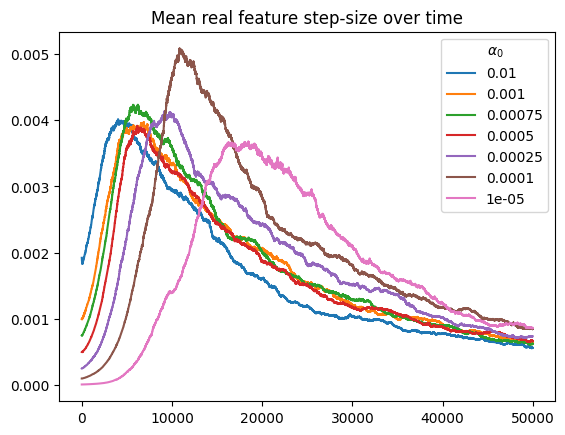

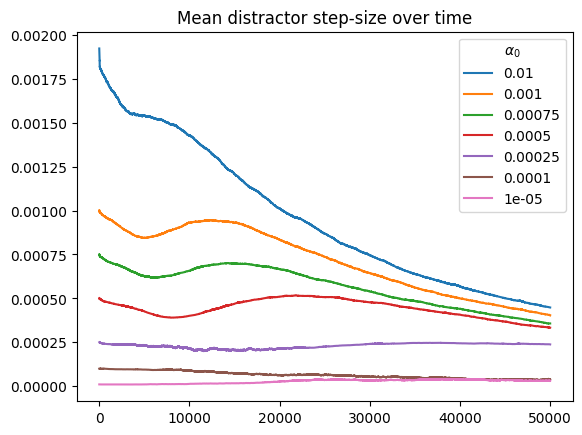

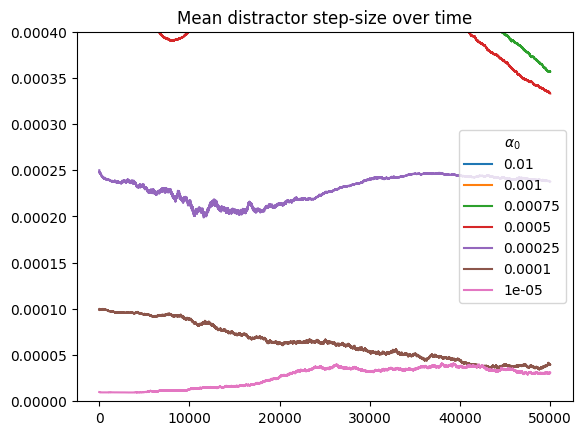

In [26]:
### Real step-sizes ###

for step_size, results in all_results.items():
    real_step_sizes = results['real_step_sizes'][:, 1:]
    mean_step_sizes = real_step_sizes.mean(axis=1)
    plt.plot(mean_step_sizes, label=str(step_size))
    
plt.legend(title='$\\alpha_0$')
plt.title('Mean real feature step-size over time')
plt.show()


### Distractor step-sizes ###

for step_size, results in all_results.items():
    distractor_step_sizes = results['distractor_step_sizes'][:, 1:]
    mean_step_sizes = distractor_step_sizes.mean(axis=1)
    plt.plot(mean_step_sizes, label=str(step_size))
    
plt.legend(title='$\\alpha_0$')
plt.title('Mean distractor step-size over time')
plt.show()


for step_size, results in all_results.items():
    distractor_step_sizes = results['distractor_step_sizes'][:, 1:]
    mean_step_sizes = distractor_step_sizes.mean(axis=1)
    plt.plot(mean_step_sizes, label=str(step_size))
    
plt.legend(title='$\\alpha_0$')
plt.title('Mean distractor step-size over time')
plt.ylim(0, 0.0004)
plt.show()